# **Bulldozer sales price estimation using Machine Learning**
This notebook explores some of the basic datascience and machine learning concepts by trying to solve the problem of Bulldozers sales price prediction.  
Since the desired outcome here is an estimate of future sales price(predicting a number) this is a **Regression** problem.  

**Problem statement:**  
> Can the future sales price of a bulldozer be predicted the machine learning techniques and models?  

**Data to solve the problem:**  
The data is taken from the *Blue Book for Bulldozers Kaggle Competition*.[(link here)](https://www.kaggle.com/c/bluebook-for-bulldozers/data)  
The data for this competition is split into three parts:

1. Train.csv is the training set, which contains data through the end of 2011.
2. Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012.
3. Test.csv is the test set. It contains data from May 1, 2012 - November 2012.

The key fields are in train.csv are:

- SalesID: the uniue identifier of the sale
- MachineID: the unique identifier of a machine.  A machine can be sold multiple times
- saleprice: what the machine sold for at auction (only provided in train.csv)
- saledate: the date of the sale  

Since this data contains data points indexed in time order(in `saledate` feature), this dataset is a **Timeseries data.**

Other than this there is a [data dictionary](https://drive.google.com/file/d/1qhPAQSFWw3rgpiMy88tMJInP0VGmoSj5/view?usp=sharing) provided with this dataset to understand more about the features of the data.  

---

## 0. Importing all necessary tools

In [1]:
# Data analysis and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Regression models from Scikit-learn library
from sklearn.ensemble import RandomForestRegressor

# Model evaluation and experimentation
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score

# saving the model
import joblib

## 1. Data loading and EDA
**Note:**  
> Data files are downloaded from [kaggle competition page](https://www.kaggle.com/c/bluebook-for-bulldozers/data) and uploaded to google drive in order to import and use it here in this notebook.  
Anyone can view the data folder used here, from this [link.](https://drive.google.com/drive/folders/1GzNp18zvT9JBbEsyjYSQnk_6mUecO6Aq?usp=sharing)  

Loading the dataset from the data folder and saving it as Pandas DataFrame. Then perform some exploratory data analysis(EDA) on the saved DataFrame.

In [2]:
# importing data from google drive folder
## since this is a timeseries data, the time feature need to be parsed into datetim object
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/bulldozer-price-prediction-data/TrainAndValid.csv",
                   parse_dates=["saledate"])
# back up the origianl data inorder to reuse it when data manipulation goes wrong
original_data = data.copy()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (13,39,40,41) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# little preview of the data
data.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,521D,521,D,NaN,NaN,NaN,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,950FII,950,F,II,NaN,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,23.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,226,226,NaN,NaN,NaN,NaN,Skid Steer Loader - 1351.0 to 1601.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,PC120-6E,PC120,NaN,-6E,NaN,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metr...",Texas,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,S175,S175,NaN,NaN,NaN,NaN,Skid Steer Loader - 1601.0 to 1751.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,EROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# features in the data
data.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [5]:
# what type of data this dataset hold?
data.dtypes

SalesID                              int64
SalePrice                          float64
MachineID                            int64
ModelID                              int64
datasource                           int64
auctioneerID                       float64
YearMade                             int64
MachineHoursCurrentMeter           float64
UsageBand                           object
saledate                    datetime64[ns]
fiModelDesc                         object
fiBaseModel                         object
fiSecondaryDesc                     object
fiModelSeries                       object
fiModelDescriptor                   object
ProductSize                         object
fiProductClassDesc                  object
state                               object
ProductGroup                        object
ProductGroupDesc                    object
Drive_System                        object
Enclosure                           object
Forks                               object
Pad_Type   

In [6]:
# are there any missing values?
data.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

So there are (lot of) missing values in the dataset and all the values present are also not in numeric data type.

### 1.1 Playing with the dataset by `saledate` feature

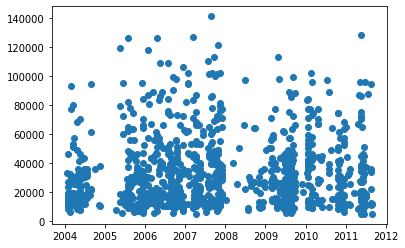

In [10]:
# visualizing the spread of saleprice over the saleyear
fig, ax = plt.subplots()
ax.scatter(data["saledate"][:1000], data["SalePrice"][:1000]);

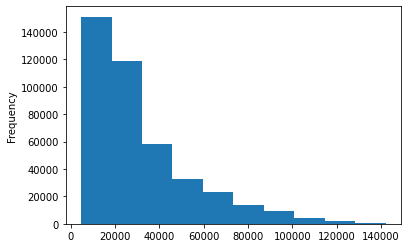

In [11]:
# looking the SalePrice distribution
data["SalePrice"].plot.hist();

In [12]:
# viewing the time stamp data
data["saledate"]

0        2006-11-16
1        2004-03-26
2        2004-02-26
3        2011-05-19
4        2009-07-23
            ...    
412693   2012-03-07
412694   2012-01-28
412695   2012-01-28
412696   2012-03-07
412697   2012-01-28
Name: saledate, Length: 412698, dtype: datetime64[ns]

The time series data is not sorted

In [13]:
# sort the examples by dateime order
data.sort_values(by="saledate", inplace=True)

In [14]:
# creating date, month and year columns from saledate column
## since the saledate column is as pandas.datatime object, the different datetime attributes can be accessed
data["SaleDay"] = data["saledate"].dt.day
data["SaleMonth"] = data["saledate"].dt.month
data["SaleYear"] = data["saledate"].dt.year

In [15]:
# dropping saledate column as there is no need that anymore
data.drop(columns="saledate", inplace=True)

### 1.2 Filling missing values & Converting non-numeric dtypes to numeric
Need to rectify missing values and non-numeric values problems in the dataset before modeling
#### 1.2.1 Changing Object dtype data into Pandas Categorical Datatype

In [16]:
# loop to check and convert string data into Pandas categorical data
for col_name, content in data.items():
    if pd.api.types.is_string_dtype(content):
        data[col_name] = content.astype("category").cat.as_ordered()

In [17]:
# checking the conversion
data.dtypes

SalesID                        int64
SalePrice                    float64
MachineID                      int64
ModelID                        int64
datasource                     int64
auctioneerID                 float64
YearMade                       int64
MachineHoursCurrentMeter     float64
UsageBand                   category
fiModelDesc                 category
fiBaseModel                 category
fiSecondaryDesc             category
fiModelSeries               category
fiModelDescriptor           category
ProductSize                 category
fiProductClassDesc          category
state                       category
ProductGroup                category
ProductGroupDesc            category
Drive_System                category
Enclosure                   category
Forks                       category
Pad_Type                    category
Ride_Control                category
Stick                       category
Transmission                category
Turbocharged                category
B

#### 1.2.2 Filling numeric missing values with median value

In [18]:
# loop to check and fill numeric missing values with median value
for col_name, content in data.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isna(content).sum():
            # creating a column to check whether the value in that column is a filled value or not
            data[col_name+"_is_missing"] = content.isna()
            # fill missing values
            data[col_name].fillna(content.median(), inplace=True)

#### 1.2.3 Filling non-numeric(categorical) missing values and/by turning them into numbers

In [22]:
# Turn categorical variables into numbers
for col_name, content in data.items():
    # Check columns which *aren't* numeric
    if not pd.api.types.is_numeric_dtype(content):
        # check non-numeric columns with missing values
        if pd.isna(content).sum():
            # Add a column to inidicate whether sample had missing value
            data[col_name+"_is_missing"] = content.isna()
        # filing and converting values outside of (second)if block so all categorical columns get converted
        data[col_name] = pd.Categorical(content).codes+1
        # accessing "content" values' "Categorical" form and their "codes" and adding "+1"
        ## Categoric form fills "-1" for missing values, so adding "+1" means filling missing values with '+ve' numbers

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 95 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   SalesID                              412698 non-null  int64  
 1   SalePrice                            412698 non-null  float64
 2   MachineID                            412698 non-null  int64  
 3   ModelID                              412698 non-null  int64  
 4   datasource                           412698 non-null  int64  
 5   auctioneerID                         412698 non-null  float64
 6   YearMade                             412698 non-null  int64  
 7   MachineHoursCurrentMeter             412698 non-null  float64
 8   UsageBand                            412698 non-null  int8   
 9   fiModelDesc                          412698 non-null  int16  
 10  fiBaseModel                          412698 non-null  int16  
 11  fiSecond

#### 1.2.4 Now we save the current preprocessed dataset into a new `.csv` file

In [24]:
data.to_csv("/content/drive/MyDrive/Colab Notebooks/bulldozer-price-prediction-data/processed_data.csv", index=False)